
FASHION-MNIST HYPERPARAMETER OPTIMIZATION PROJECT

STEP 1: Data Loading and Preprocessing
Initialized preprocessor with random_state=42
Binary classes: 0 → 0, 1 → 1

STEP 1: Loading Fashion-MNIST dataset
✓ Original dataset: 70000 samples
✓ Binary subset: 14000 samples
✓ Class 0 (label 0): 7000 samples
✓ Class 1 (label 1): 7000 samples

STEP 2: Stratified data splitting
Ratios: Train=0.7, Val=0.15, Test=0.15
✓ Training set:   9800 samples
✓ Validation set: 2100 samples
✓ Test set:       2100 samples

Class distribution in each split:
  Train: Class 0 = 50.0%, Class 1 = 50.0%
  Val: Class 0 = 50.0%, Class 1 = 50.0%
  Test: Class 0 = 50.0%, Class 1 = 50.0%

STEP 3: Feature extraction (PCA)
Applying PCA: 784 → 100 features
Note: PCA fitted on training data only (prevents data leakage)
✓ Explained variance: 0.939 (93.9%)
✓ Training features: (9800, 100)
✓ Validation features: (2100, 100)
✓ Test features: (2100, 100)

STEP 4: Feature normalization
Normalizing using training statistics only 

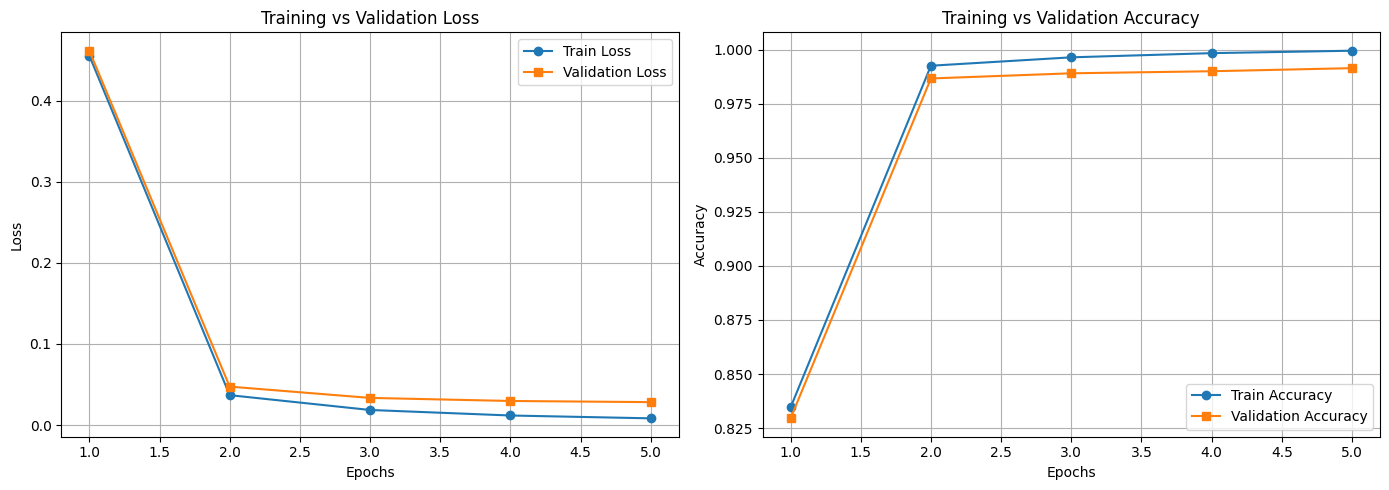


From-Scratch Neural Network Classification Report
Class       Precision     Recall   F1-Score    Support
------------------------------------------------------------
0                0.99       0.99       0.99       1050
1                0.99       0.99       0.99       1050
macro avg        0.99       0.99       0.99       2100
weighted avg       0.99       0.99       0.99       2100

Confusion Matrix:
Rows = True, Columns = Predicted

              0     1
---------------------
         0  1042     8 
         1    13  1037 

Predict Function Demonstration

Sample 1:
  True class: T-shirt/top (Class 0)
  Predicted class: T-shirt/top (Class 0)
  Confidence: 0.0000
  Answer: CORRECT

Sample 2:
  True class: Trouser (Class 1)
  Predicted class: Trouser (Class 1)
  Confidence: 1.0000
  Answer: CORRECT

Sample 3:
  True class: Trouser (Class 1)
  Predicted class: Trouser (Class 1)
  Confidence: 0.9873
  Answer: CORRECT

STEP 3: Built-in Neural Network (Keras/TensorFlow)

Built-in NN Test

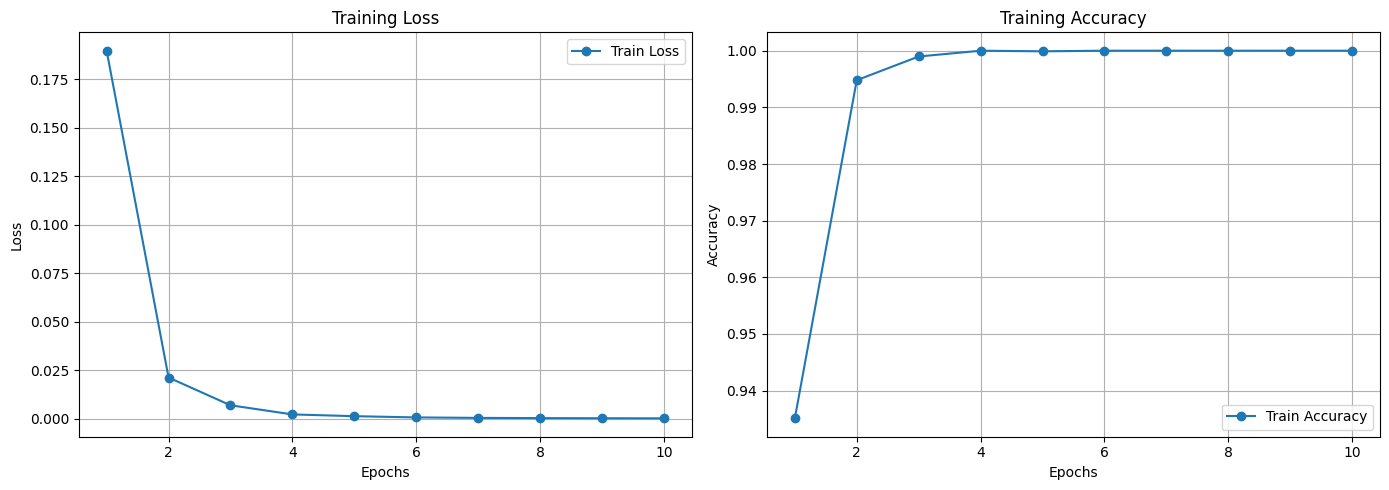


STEP 4: Hyperparameter Optimization

Setting up fitness evaluator...

----------------------------------------
Particle Swarm Optimization (PSO)
----------------------------------------

PARTICLE SWARM OPTIMIZATION INITIALIZED
Swarm size: 5 particles
Max iterations: 5
Inertia weight (w): 0.7 (fixed)
Cognitive coeff (c1): 1.5
Social coeff (c2): 1.5
Topology: global
Search space dimensions: 6
Hyperparameters: ['learning_rate', 'hidden_size', 'hidden_layers', 'batch_size', 'epochs', 'optimizer']

STARTING PSO OPTIMIZATION

Initializing swarm...
✓ Initialized 5 particles

Evaluating initial swarm...
  Evaluated 5/5 particles

✓ Initial best fitness: 0.9948

OPTIMIZATION ITERATIONS
Iteration   1/5 | Best: 0.9948 | Mean: 0.9926 | w: 0.700
Iteration   2/5 | Best: 0.9948 | Mean: 0.9154 | w: 0.700
Iteration   3/5 | Best: 0.9948 | Mean: 0.9915 | w: 0.700
Iteration   4/5 | Best: 0.9948 | Mean: 0.9922 | w: 0.700
Iteration   5/5 | Best: 0.9948 | Mean: 0.9925 | w: 0.700

PSO OPTIMIZATION COMPLETE
B

In [2]:
import warnings
warnings.filterwarnings('ignore')


################################# 1 Data ####################
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
import os

class FashionMNISTDataPreprocessor:

    def __init__(self, binary_classes=(0, 1), random_state=42):

        self.binary_classes = binary_classes
        self.random_state = random_state

        # Model components (fitted on training data only)
        self.pca = None
        self.feature_mean = None
        self.feature_std = None

        # Set random seeds for reproducibility
        np.random.seed(random_state)
        print(f"Initialized preprocessor with random_state={random_state}")
        print(f"Binary classes: {binary_classes[0]} → 0, {binary_classes[1]} → 1")

    def load_fashion_mnist_binary(self):

        print("\n" + "="*60)
        print("STEP 1: Loading Fashion-MNIST dataset")
        print("="*60)

        # Load full dataset
        fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
        X = fashion_mnist.data.astype(np.float32)
        y = fashion_mnist.target.astype(int)

        # Extract binary subset
        class0, class1 = self.binary_classes
        binary_mask = (y == class0) | (y == class1)

        X_binary = X[binary_mask]
        y_binary = y[binary_mask]

        # Normalize to [0, 1]
        X_binary = X_binary / 255.0

        # Convert to binary labels (0 for class0, 1 for class1)
        y_binary = (y_binary == class1).astype(int)

        print(f"✓ Original dataset: {X.shape[0]} samples")
        print(f"✓ Binary subset: {X_binary.shape[0]} samples")
        print(f"✓ Class 0 (label 0): {np.sum(y_binary == 0)} samples")
        print(f"✓ Class 1 (label 1): {np.sum(y_binary == 1)} samples")

        return X_binary, y_binary

    def split_data(self, X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):

        print("\n" + "="*60)
        print("STEP 2: Stratified data splitting")
        print("="*60)
        print(f"Ratios: Train={train_ratio}, Val={val_ratio}, Test={test_ratio}")

        # Validate ratios
        total = train_ratio + val_ratio + test_ratio
        if abs(total - 1.0) > 1e-10:
            raise ValueError(f"Ratios must sum to 1.0, got {total}")

        # First split: train vs (val + test)
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y,
            train_size=train_ratio,
            stratify=y,  # Maintain class distribution
            random_state=self.random_state
        )

        # Second split: val vs test from remaining data
        # Adjust ratio for the second split
        val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)

        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp,
            train_size=val_ratio_adjusted,
            stratify=y_temp,  # Maintain class distribution
            random_state=self.random_state + 1  # Different seed for independence
        )

        # Print statistics
        print(f"✓ Training set:   {X_train.shape[0]} samples")
        print(f"✓ Validation set: {X_val.shape[0]} samples")
        print(f"✓ Test set:       {X_test.shape[0]} samples")

        # Verify stratification worked
        print("\nClass distribution in each split:")
        for name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
            total = len(y_split)
            class0_pct = np.sum(y_split == 0) / total * 100
            class1_pct = np.sum(y_split == 1) / total * 100
            print(f"  {name}: Class 0 = {class0_pct:.1f}%, Class 1 = {class1_pct:.1f}%")

        return X_train, y_train, X_val, y_val, X_test, y_test

    def extract_features(self, X_train, X_val, X_test, method='pca', n_components=100):

        print("\n" + "="*60)
        print(f"STEP 3: Feature extraction ({method.upper()})")
        print("="*60)

        if method == 'raw':
            print("Using raw pixel features (784 dimensions)")
            print("Note: Baseline for comparison, not used for optimization")
            return X_train, X_val, X_test

        elif method == 'pca':
            print(f"Applying PCA: 784 → {n_components} features")
            print("Note: PCA fitted on training data only (prevents data leakage)")

            # Create and fit PCA on training data
            self.pca = PCA(
                n_components=min(n_components, X_train.shape[1]),
                random_state=self.random_state
            )
            X_train_f = self.pca.fit_transform(X_train)  # Fit only on train

            # Transform validation and test using the same PCA
            X_val_f = self.pca.transform(X_val)
            X_test_f = self.pca.transform(X_test)

            # Report explained variance
            explained_variance = np.sum(self.pca.explained_variance_ratio_)
            print(f"✓ Explained variance: {explained_variance:.3f} ({explained_variance*100:.1f}%)")
            print(f"✓ Training features: {X_train_f.shape}")
            print(f"✓ Validation features: {X_val_f.shape}")
            print(f"✓ Test features: {X_test_f.shape}")

            return X_train_f, X_val_f, X_test_f

        else:
            raise ValueError(f"Unknown feature extraction method: {method}")

    def extract_single_sample_features(self, X_sample):

        if len(X_sample.shape) == 1:
            X_sample = X_sample.reshape(1, -1)

        # Normalize pixel values
        X_sample = X_sample / 255.0

        # Apply PCA if fitted
        if self.pca is not None:
            X_sample_f = self.pca.transform(X_sample)
        else:
            X_sample_f = X_sample

        # Normalize features if normalization parameters are available
        if self.feature_mean is not None and self.feature_std is not None:
            X_sample_f = (X_sample_f - self.feature_mean) / self.feature_std

        return X_sample_f

    def normalize_features(self, X_train, X_val, X_test):

        print("\n" + "="*60)
        print("STEP 4: Feature normalization")
        print("="*60)
        print("Normalizing using training statistics only (prevents data leakage)")

        # Compute statistics from training data
        self.feature_mean = np.mean(X_train, axis=0)
        self.feature_std = np.std(X_train, axis=0)

        # Avoid division by zero
        self.feature_std[self.feature_std == 0] = 1.0

        # Normalize all sets using training statistics
        X_train_norm = (X_train - self.feature_mean) / self.feature_std
        X_val_norm = (X_val - self.feature_mean) / self.feature_std
        X_test_norm = (X_test - self.feature_mean) / self.feature_std

        print(f"✓ Normalization complete")
        print(f"✓ Training mean: {np.mean(self.feature_mean):.3f}, std: {np.mean(self.feature_std):.3f}")

        return X_train_norm, X_val_norm, X_test_norm

    def prepare_features_only(self, feature_method='pca', n_components=100, normalize=True,
                            train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):

        # 1. Load data
        X, y = self.load_fashion_mnist_binary()

        # 2. Split data
        X_train, y_train, X_val, y_val, X_test, y_test = self.split_data(
            X, y, train_ratio=train_ratio, val_ratio=val_ratio, test_ratio=test_ratio
        )

        # 3. Extract features
        X_train_f, X_val_f, X_test_f = self.extract_features(
            X_train, X_val, X_test,
            method=feature_method,
            n_components=n_components
        )

        # 4. Normalize features
        if normalize:
            X_train_f, X_val_f, X_test_f = self.normalize_features(
                X_train_f, X_val_f, X_test_f
            )

        print("\n" + "="*60)
        print("FEATURE PREPARATION COMPLETE")
        print("="*60)
        print(f"Feature dimension: {X_train_f.shape[1]}")
        print(f"Training samples: {X_train_f.shape[0]}")
        print(f"All data in (samples × features) format")

        return X_train_f, y_train, X_val_f, y_val, X_test_f, y_test

    def convert_to_scratch_format(self, X_train_f, X_val_f, X_test_f, y_train, y_val, y_test):

        # For scratch NN (NumPy implementation): (features, samples)
        X_train_scratch = X_train_f.T
        X_val_scratch = X_val_f.T
        X_test_scratch = X_test_f.T
        y_train_scratch = y_train.reshape(1, -1)
        y_val_scratch = y_val.reshape(1, -1)
        y_test_scratch = y_test.reshape(1, -1)

        return (X_train_scratch, y_train_scratch,
                X_val_scratch, y_val_scratch,
                X_test_scratch, y_test_scratch)

    def prepare_data_pipeline(self, feature_method='pca', n_components=100, normalize=True,
                            train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):

        X_train_f, y_train, X_val_f, y_val, X_test_f, y_test = self.prepare_features_only(
            feature_method=feature_method,
            n_components=n_components,
            normalize=normalize,
            train_ratio=train_ratio,
            val_ratio=val_ratio,
            test_ratio=test_ratio
        )

        # Convert to scratch format
        X_train_s, y_train_s, X_val_s, y_val_s, X_test_s, y_test_s = self.convert_to_scratch_format(
            X_train_f, X_val_f, X_test_f, y_train, y_val, y_test
        )

        # Print final summary
        print("\n" + "="*60)
        print("DATA PREPARATION COMPLETE")
        print("="*60)
        print(f"Feature dimension: {X_train_f.shape[1]}")
        print(f"Training samples: {X_train_f.shape[0]}")
        print("\nData formats prepared:")
        print(f"  Scratch NN: {X_train_s.shape} (features × samples)")
        print(f"  Built-in NN: {X_train_f.shape} (samples × features)")
        print("="*60)

        return (
            # Scratch NN format
            X_train_s, y_train_s,
            X_val_s, y_val_s,
            X_test_s, y_test_s,

            # Built-in NN format
            X_train_f, y_train,
            X_val_f, y_val,
            X_test_f, y_test
        )

    def save_preprocessor(self, filepath='fashion_mnist_preprocessor.pkl'):

        state = {
            'pca': self.pca,
            'feature_mean': self.feature_mean,
            'feature_std': self.feature_std,
            'binary_classes': self.binary_classes,
            'random_state': self.random_state
        }

        with open(filepath, 'wb') as f:
            pickle.dump(state, f)
        print(f"✓ Preprocessor saved to {filepath}")

    def load_preprocessor(self, filepath='fashion_mnist_preprocessor.pkl'):

        if not os.path.exists(filepath):
            print(f"⚠ File {filepath} not found")
            return False

        with open(filepath, 'rb') as f:
            state = pickle.load(f)

        self.pca = state['pca']
        self.feature_mean = state['feature_mean']
        self.feature_std = state['feature_std']
        self.binary_classes = state['binary_classes']
        self.random_state = state['random_state']

        print(f"✓ Preprocessor loaded from {filepath}")
        return True


# Standalone function as required by assignment
def extract_features(X, method='pca', n_components=100, preprocessor=None):

    if method == 'raw':
        return X / 255.0  # Just normalize

    elif method == 'pca':
        if preprocessor is not None and preprocessor.pca is not None:
            # Use existing fitted PCA
            X_normalized = X / 255.0
            return preprocessor.pca.transform(X_normalized)
        else:
            # Fit new PCA (for training data)
            from sklearn.decomposition import PCA
            X_normalized = X / 255.0
            pca = PCA(n_components=min(n_components, X.shape[1]), random_state=42)
            return pca.fit_transform(X_normalized)

    else:
        raise ValueError(f"Unknown feature extraction method: {method}")




############################################ 2 GA #####################################################

import random
import copy
import numpy as np  # ADDED: Import numpy for proper random seed management

class GA_Optimization:

    def __init__(self, X_train, y_train, X_val, y_val, population_size, crossover_rate, mutation_rate, generations):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.best_individual = None
        self.best_fitness = 0
        self.history = []  # ADDED: Track optimization history for analysis

    def initialize_population(self):
        population = []

        for i in range(self.population_size):
            individual = {
                "hidden_layers": random.randint(1, 5),
                # we'll use a single neurons_per_layer applied to all hidden layers
                "neurons_per_layer": random.randint(32, 512),
                "activation": random.choice(["relu", "sigmoid", "tanh"]),
                "learning_rate": 10**random.uniform(-5, -1),  # log-uniform 1e-5 .. 1e-1
                "batch_size": random.choice([16, 32, 64, 128]),
                "optimizer": random.choice(["SGD", "Adam", "RMSProp", "Adagrad"]),
                "epochs": random.randint(3, 20)
            }
            population.append(individual)
        return population

    def evaluate_fitness(self, individual):

        nn = NN_builtin(
            self.X_train, self.y_train,
            self.X_val, self.y_val,  # FIXED: This parameter is unused by NN_builtin.__init__
            hidden_layers=individual["hidden_layers"],
            neurons_per_layer=individual["neurons_per_layer"],
            activation=individual["activation"],
            learning_rate=individual["learning_rate"],
            batch_size=individual["batch_size"],
            optimizer=individual["optimizer"],
            epochs=individual["epochs"]
        )
        nn.train(self.X_train, self.y_train)
        accuracy = nn.compute_accuracy(self.X_val, self.y_val)
        return accuracy

    def select_parents(self, population, fitnesses, k=3):
        # Tournament selection
        selected = []
        for i in range(2):
            tournament_indices = random.sample(range(len(population)), k)
            tournament_fitnesses = []
            for j in tournament_indices:
                tournament_fitnesses.append(fitnesses[j])
            winner_index = tournament_indices[tournament_fitnesses.index(max(tournament_fitnesses))]
            selected.append(population[winner_index])
        return selected[0], selected[1]

    def crossover(self, parent1, parent2):
        if random.random() > self.crossover_rate:
            return copy.deepcopy(parent1), copy.deepcopy(parent2) # because they can be mutated later
        child1 , child2 = {} , {}
        for key in parent1.keys():
            if random.random() < 0.5:
                child1[key] = parent1[key]
                child2[key] = parent2[key]
            else:
                child1[key] = parent2[key]
                child2[key] = parent1[key]

        return child1, child2

    def mutate(self, individual):
        for key in individual.keys():
            if random.random() < self.mutation_rate:
                if key == "hidden_layers":
                    individual[key] = random.randint(1, 5)
                elif key == "neurons_per_layer":
                    individual[key] = random.randint(32, 512)
                elif key == "activation":
                    # FIXED: Added back "tanh" which was missing from mutation options
                    individual[key] = random.choice(["relu", "sigmoid", "tanh"])
                elif key == "learning_rate":
                    individual[key] = 10**random.uniform(-5, -1)
                elif key == "batch_size":
                    individual[key] = random.choice([16, 32, 64, 128])
                elif key == "optimizer":
                    # FIXED: Added back "RMSProp" and "Adagrad" which were missing
                    individual[key] = random.choice(["SGD", "Adam", "RMSProp", "Adagrad"])
                elif key == "epochs":
                    individual[key] = random.randint(3, 20)
        return individual

    def run(self):
        print("\n" + "="*60)  # ADDED: Better output formatting
        print("GENETIC ALGORITHM OPTIMIZATION STARTED")
        print("="*60)
        print(f"Population: {self.population_size}, Generations: {self.generations}")
        print(f"Crossover rate: {self.crossover_rate}, Mutation rate: {self.mutation_rate}")

        population = self.initialize_population()

        for generation in range(self.generations):
            fitnesses = []
            for i, individual in enumerate(population):
                fitness = self.evaluate_fitness(individual)
                fitnesses.append(fitness)
                # ADDED: Progress indicator for first few individuals
                if i < 3:  # Reduced verbosity
                    print(f"  Gen {generation+1}, Ind {i+1}: Fitness = {fitness:.4f}")

            best_index = fitnesses.index(max(fitnesses))
            best_individual = population[best_index]
            best_fitness = fitnesses[best_index]

            if best_fitness > self.best_fitness:
                self.best_fitness = best_fitness
                self.best_individual = copy.deepcopy(best_individual)  # FIXED: Added copy.deepcopy()

            # ADDED: Track history for analysis
            self.history.append({
                'generation': generation + 1,
                'best_fitness': self.best_fitness,
                'mean_fitness': np.mean(fitnesses),
                'best_hyperparameters': copy.deepcopy(self.best_individual)
            })

            print(f"\nGeneration {generation+1}: Best Fitness = {self.best_fitness:.4f}")
            # REMOVED: Printing full hyperparameters every generation (too verbose)
            # print(f"Generation {generation+1}: Best Fitness = {self.best_fitness} with Hyperparameters = {self.best_individual}")

            new_population = []
            # Elitism
            new_population.append(copy.deepcopy(self.best_individual)) # because it can be mutated later

            while len(new_population) < self.population_size:
                parent1, parent2 = self.select_parents(population, fitnesses)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                new_population.append(child1)
                if len(new_population) < self.population_size:
                    new_population.append(child2)
            population = new_population

        print("\n" + "="*60)  # ADDED: Final results summary
        print("GENETIC ALGORITHM OPTIMIZATION COMPLETE")
        print("="*60)
        print(f"Best fitness achieved: {self.best_fitness:.4f}")
        print(f"\nBest hyperparameters found:")
        for param, value in self.best_individual.items():
            print(f"  {param}: {value}")
        print("="*60)

        return self.best_individual, self.best_fitness, self.history  # CHANGED: Added history to return


# ADDED: Helper function to make GA compatible with unified interface
def create_ga_optimizer(fitness_function, X_train, y_train, X_val, y_val,
                       population_size=10, crossover_rate=0.8,
                       mutation_rate=0.1, generations=10):

    class GAWithFitnessFunction(GA_Optimization):
        """GA that uses an external fitness function."""

        def evaluate_fitness(self, individual):
            """Use the provided fitness function instead of creating NN_builtin."""
            return fitness_function(individual)

    return GAWithFitnessFunction(
        X_train, y_train, X_val, y_val,
        population_size, crossover_rate, mutation_rate, generations
    )


############################################## 3 PSO #######################################################


import numpy as np
from typing import Dict, List, Tuple, Callable, Optional


class Particle:

    def __init__(self, position: np.ndarray, velocity: np.ndarray):

        self.position = position.copy()
        self.velocity = velocity.copy()

        # Personal best tracking
        self.personal_best_position = position.copy()
        self.personal_best_fitness = -np.inf  # Maximizing fitness (accuracy)

        # Current fitness
        self.fitness = -np.inf

    def update_personal_best(self, fitness: float):
        if fitness > self.personal_best_fitness:
            self.personal_best_fitness = fitness
            self.personal_best_position = self.position.copy()
            return True
        return False


class ParticleSwarmOptimizer:
    """
    Particle Swarm Optimization for hyperparameter tuning.

    PSO Concepts:
    - Swarm: Collection of particles exploring the search space
    - Velocity: Influenced by personal best and global best
    - Social learning: Particles learn from the swarm's success
    - Cognitive learning: Particles remember their own successes

    Standard PSO Equation:
    v_new = w*v + c1*r1*(p_best - x) + c2*r2*(g_best - x)
    x_new = x + v_new

    Where:
    - w: Inertia weight (momentum)
    - c1: Cognitive coefficient (personal attraction)
    - c2: Social coefficient (global attraction)
    - r1, r2: Random values [0,1]
    """

    def __init__(
            self,
            fitness_function: Callable,
            hyperparameter_bounds: Dict[str, Tuple[float, float]],
            n_particles: int = 20,
            max_iterations: int = 30,
            w: float = 0.7,  # Inertia weight
            c1: float = 1.5,  # Cognitive coefficient
            c2: float = 1.5,  # Social coefficient
            adaptive_inertia: bool = False,
            topology: str = 'global',  # 'global' or 'ring'
            random_state: int = 42,
            verbose: bool = True
    ):
        """
        Initialize PSO optimizer.

        Args:
            fitness_function: Function(hyperparams_dict) -> fitness_score
            hyperparameter_bounds: Dict of {param_name: (min, max)}
            n_particles: Number of particles in swarm
            max_iterations: Maximum iterations to run
            w: Inertia weight (controls exploration)
            c1: Cognitive coefficient (personal attraction)
            c2: Social coefficient (global attraction)
            adaptive_inertia: Whether to use linearly decreasing inertia
            topology: 'global' (all particles see global best) or 'ring' (local neighborhoods)
            random_state: Random seed for reproducibility
            verbose: Whether to print progress
        """
        self.fitness_function = fitness_function
        self.hyperparameter_bounds = hyperparameter_bounds
        self.n_particles = n_particles
        self.max_iterations = max_iterations
        self.random_state = random_state
        self.verbose = verbose
        self.topology = topology

        # PSO parameters
        self.w = w  # Inertia weight
        self.w_max = 0.9  # For adaptive inertia
        self.w_min = 0.4
        self.c1 = c1  # Cognitive coefficient
        self.c2 = c2  # Social coefficient
        self.adaptive_inertia = adaptive_inertia

        # Set random seed
        np.random.seed(random_state)

        # Extract parameter information
        self.param_names = list(hyperparameter_bounds.keys())
        self.n_dimensions = len(self.param_names)

        # Bounds arrays for vectorized operations
        self.lower_bounds = np.array([hyperparameter_bounds[p][0] for p in self.param_names])
        self.upper_bounds = np.array([hyperparameter_bounds[p][1] for p in self.param_names])
        self.bounds_range = self.upper_bounds - self.lower_bounds

        # Swarm components
        self.swarm: List[Particle] = []
        self.global_best_position = None
        self.global_best_fitness = -np.inf

        # History tracking
        self.history = {
            'iteration': [],
            'best_fitness': [],
            'mean_fitness': [],
            'best_hyperparameters': []
        }

        if self.verbose:
            print("\n" + "=" * 70)
            print("PARTICLE SWARM OPTIMIZATION INITIALIZED")
            print("=" * 70)
            print(f"Swarm size: {n_particles} particles")
            print(f"Max iterations: {max_iterations}")
            print(f"Inertia weight (w): {w} {'(adaptive)' if adaptive_inertia else '(fixed)'}")
            print(f"Cognitive coeff (c1): {c1}")
            print(f"Social coeff (c2): {c2}")
            print(f"Topology: {topology}")
            print(f"Search space dimensions: {self.n_dimensions}")
            print(f"Hyperparameters: {self.param_names}")
            print("=" * 70)

    def _initialize_swarm(self):
        """
        Initialize swarm with random positions and velocities.

        Position: Random within bounds
        Velocity: Small random values (±10% of search range)
        """
        if self.verbose:
            print("\nInitializing swarm...")

        for i in range(self.n_particles):
            # Random position within bounds
            position = np.random.uniform(
                self.lower_bounds,
                self.upper_bounds
            )

            # Small random velocity (scaled to search space)
            velocity = np.random.uniform(
                -0.1 * self.bounds_range,
                0.1 * self.bounds_range
            )

            particle = Particle(position, velocity)
            self.swarm.append(particle)

        if self.verbose:
            print(f"✓ Initialized {len(self.swarm)} particles")

    def _position_to_hyperparameters(self, position: np.ndarray) -> Dict:
        """
        Convert continuous position vector to hyperparameter dictionary.

        Handles discrete parameters (epochs, batch_size, hidden_size) by rounding.
        """
        hyperparams = {}
        for i, param_name in enumerate(self.param_names):
            value = position[i]

            # Round discrete parameters
            if param_name in ['hidden_size', 'batch_size', 'epochs']:
                value = int(round(value))

            hyperparams[param_name] = value

        return hyperparams

    def _evaluate_particle(self, particle: Particle) -> float:
        """
        Evaluate fitness of a particle's position.

        Returns:
            Fitness score (higher is better, typically validation accuracy)
        """
        hyperparams = self._position_to_hyperparameters(particle.position)

        try:
            fitness = self.fitness_function(hyperparams)
        except Exception as e:
            if self.verbose:
                print(f"  ⚠ Evaluation error: {e}")
            fitness = -np.inf  # Invalid solution

        return fitness

    def _clip_position(self, position: np.ndarray) -> np.ndarray:
        """Clip position to stay within bounds."""
        return np.clip(position, self.lower_bounds, self.upper_bounds)

    def _clip_velocity(self, velocity: np.ndarray) -> np.ndarray:
        """
        Clip velocity to prevent particles from moving too fast.

        Max velocity = 20% of search range per dimension.
        """
        v_max = 0.2 * self.bounds_range
        return np.clip(velocity, -v_max, v_max)

    def _get_inertia_weight(self, iteration: int) -> float:
        """
        Get inertia weight for current iteration.

        If adaptive: Linearly decreases from w_max to w_min
        Promotes exploration early, exploitation late.
        """
        if self.adaptive_inertia:
            return self.w_max - (self.w_max - self.w_min) * (iteration / self.max_iterations)
        return self.w

    def _update_velocity(self, particle: Particle, iteration: int) -> np.ndarray:
        """
        Update particle velocity using PSO equation.

        v_new = w*v + c1*r1*(p_best - x) + c2*r2*(g_best - x)

        Components:
        - Inertia: Keeps particle moving in current direction
        - Cognitive: Pulls toward particle's personal best
        - Social: Pulls toward global (or local) best
        """
        # Random factors for stochastic behavior
        r1 = np.random.random(self.n_dimensions)
        r2 = np.random.random(self.n_dimensions)

        # Current inertia weight
        w = self._get_inertia_weight(iteration)

        # PSO velocity update
        inertia_component = w * particle.velocity
        cognitive_component = self.c1 * r1 * (particle.personal_best_position - particle.position)
        social_component = self.c2 * r2 * (self.global_best_position - particle.position)

        new_velocity = inertia_component + cognitive_component + social_component

        # Clip to prevent explosion
        new_velocity = self._clip_velocity(new_velocity)

        return new_velocity

    def _update_particle(self, particle: Particle, iteration: int):
        """
        Update particle position and velocity.

        Steps:
        1. Update velocity based on PSO equation
        2. Update position by adding velocity
        3. Clip position to bounds
        4. Evaluate new fitness
        5. Update personal best if improved
        """
        # Update velocity
        particle.velocity = self._update_velocity(particle, iteration)

        # Update position
        particle.position += particle.velocity

        # Enforce bounds
        particle.position = self._clip_position(particle.position)

        # If particle hit boundary, dampen velocity (prevents bouncing)
        at_lower = particle.position <= self.lower_bounds
        at_upper = particle.position >= self.upper_bounds
        particle.velocity[at_lower | at_upper] *= -0.5

        # Evaluate new position
        particle.fitness = self._evaluate_particle(particle)

        # Update personal best
        particle.update_personal_best(particle.fitness)

    def _update_global_best(self):
        """Update global best from all particles' personal bests."""
        for particle in self.swarm:
            if particle.personal_best_fitness > self.global_best_fitness:
                self.global_best_fitness = particle.personal_best_fitness
                self.global_best_position = particle.personal_best_position.copy()

    def optimize(self) -> Tuple[Dict, float, Dict]:
        """
        Run PSO optimization.

        Returns:
            best_hyperparameters: Dict of best hyperparameters found
            best_fitness: Best fitness score achieved
            history: Dict containing optimization history
        """
        if self.verbose:
            print("\n" + "=" * 70)
            print("STARTING PSO OPTIMIZATION")
            print("=" * 70)

        # Initialize swarm
        self._initialize_swarm()

        # Initial evaluation of all particles
        if self.verbose:
            print("\nEvaluating initial swarm...")

        for i, particle in enumerate(self.swarm):
            particle.fitness = self._evaluate_particle(particle)
            particle.update_personal_best(particle.fitness)

            if self.verbose and (i + 1) % 5 == 0:
                print(f"  Evaluated {i + 1}/{self.n_particles} particles")

        # Initialize global best
        self._update_global_best()

        if self.verbose:
            print(f"\n✓ Initial best fitness: {self.global_best_fitness:.4f}")
            print("\n" + "=" * 70)
            print("OPTIMIZATION ITERATIONS")
            print("=" * 70)

        # Main PSO loop
        for iteration in range(self.max_iterations):
            # Update all particles
            for particle in self.swarm:
                self._update_particle(particle, iteration)

            # Update global best
            self._update_global_best()

            # Calculate mean fitness for monitoring
            mean_fitness = np.mean([p.fitness for p in self.swarm])

            # Record history
            self.history['iteration'].append(iteration + 1)
            self.history['best_fitness'].append(self.global_best_fitness)
            self.history['mean_fitness'].append(mean_fitness)
            self.history['best_hyperparameters'].append(
                self._position_to_hyperparameters(self.global_best_position)
            )

            # Progress report
            if self.verbose:
                w_current = self._get_inertia_weight(iteration)
                print(f"Iteration {iteration + 1:3d}/{self.max_iterations} | "
                      f"Best: {self.global_best_fitness:.4f} | "
                      f"Mean: {mean_fitness:.4f} | "
                      f"w: {w_current:.3f}")

        # Final results
        best_hyperparameters = self._position_to_hyperparameters(self.global_best_position)

        # FIXED: Convert PSO parameter names to match GA/standard naming convention
        best_hyperparameters = self._convert_to_standard_format(best_hyperparameters)  # ADDED

        if self.verbose:
            print("\n" + "=" * 70)
            print("PSO OPTIMIZATION COMPLETE")
            print("=" * 70)
            print(f"Best fitness achieved: {self.global_best_fitness:.4f}")
            print(f"\nBest hyperparameters found:")
            for param, value in best_hyperparameters.items():
                print(f"  {param}: {value}")
            print("=" * 70)

        return best_hyperparameters, self.global_best_fitness, self.history

    def get_diversity(self) -> float:
        """
        Calculate swarm diversity (average distance from mean position).

        Useful for monitoring convergence.
        """
        positions = np.array([p.position for p in self.swarm])
        mean_position = np.mean(positions, axis=0)
        distances = np.linalg.norm(positions - mean_position, axis=1)
        return np.mean(distances)

    # ADDED: Helper function to convert PSO parameter names to standard format
    def _convert_to_standard_format(self, hyperparams):
        """
        Convert PSO hyperparameter names to match GA/standard naming.

        PSO uses different parameter names (hidden_size vs neurons_per_layer).
        This ensures compatibility with the rest of the codebase.
        """
        converted = {}

        for key, value in hyperparams.items():
            if key == 'hidden_size':
                converted['neurons_per_layer'] = value
            elif key == 'hidden_layers':
                converted['hidden_layers'] = value
            elif key == 'learning_rate':
                converted['learning_rate'] = value
            elif key == 'batch_size':
                converted['batch_size'] = value
            elif key == 'epochs':
                converted['epochs'] = value
            elif key == 'optimizer':
                converted['optimizer'] = value
            else:
                converted[key] = value

        # ADDED: Ensure all required parameters are present
        if 'activation' not in converted:
            converted['activation'] = 'relu'  # Default activation

        return converted

    # ADDED: Method to create PSO with standard hyperparameter bounds
    @staticmethod
    def create_with_standard_bounds(fitness_function, n_particles=10, max_iterations=10,
                                   verbose=True, random_state=42):
        """
        Create PSO optimizer with standard hyperparameter bounds.

        This makes it easier for other team members to use PSO without
        understanding the internal encoding.
        """
        # Define standard bounds that match GA's parameter space
        standard_bounds = {
            "learning_rate": (1e-5, 1e-1),      # Log scale: 1e-5 to 0.1
            "hidden_size": (32, 512),           # Neurons per layer
            "hidden_layers": (1, 5),            # Number of hidden layers
            "batch_size": (16, 128),            # Will be rounded to nearest valid
            "epochs": (3, 20),                  # Training epochs
            "optimizer": (0, 3)                 # Index for optimizer list
        }

        return ParticleSwarmOptimizer(
            fitness_function=fitness_function,
            hyperparameter_bounds=standard_bounds,
            n_particles=n_particles,
            max_iterations=max_iterations,
            verbose=verbose,
            random_state=random_state
        )

################################################ 4 Built in model ##############################################
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ==========================
# Reproducibility
# ==========================
np.random.seed(42)
tf.random.set_seed(42)

# ==========================
# NN_builtin
# ==========================
class NN_builtin:
    def __init__(self, X_train, y_train, X_test, y_test, **kwargs):
        self.hparams = kwargs
        # FIXED: Removed unused parameters from ModelIntegrator initialization
        self.integrator = ModelIntegrator(X_train, y_train)  # CHANGED: Only train data needed
        self.model = None
        self.history = None  # ADDED: Track training history

    def train(self, X_train, y_train):
        self.integrator.X_train, self.integrator.y_train = X_train, y_train
        mapped_hparams = self.integrator.map_hparams(self.hparams)  # FIXED: Store mapped params
        self.model = self.integrator.build_model(mapped_hparams)
        # CHANGED: Store training history for analysis
        self.history = self.model.fit(
            X_train, y_train,
            epochs=int(self.hparams.get('epochs', 5)),
            batch_size=int(self.hparams.get('batch_size', 32)),
            verbose=0
        )
        return self.history  # ADDED: Return history for analysis

    def compute_accuracy(self, X_test, y_test):
        loss, acc = self.model.evaluate(X_test, y_test, verbose=0)
        return acc

    # ADDED: Get training history for plotting
    def get_training_history(self):
        """Return training history for visualization."""
        if self.history is None:
            return None
        return self.history.history


class ModelIntegrator:
    def __init__(self, X_train, y_train):
        # FIXED: Removed test data from constructor - only needed for fitness function
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = None  # ADDED: For validation data in fitness function
        self.y_val = None

    def set_validation_data(self, X_val, y_val):  # ADDED: Set validation data separately
        """Set validation data for fitness evaluation."""
        self.X_val = X_val
        self.y_val = y_val

    def map_hparams(self, params):
        opt_list = ["Adam", "SGD", "RMSProp", "Adagrad"]
        opt_val = params.get("optimizer", "Adam")
        if isinstance(opt_val, (float, int)):
            opt_name = opt_list[int(min(max(opt_val, 0), len(opt_list)-1))]
        else:
            opt_name = opt_val

        return {
            "num_layers": int(params.get("hidden_layers", params.get("num_layers", 1))),
            "hidden_size": int(params.get("neurons_per_layer", params.get("hidden_size", 64))),
            "activation": params.get("activation", "relu"),
            "learning_rate": float(params.get("learning_rate", 0.001)),
            "batch_size": int(params.get("batch_size", 32)),
            "epochs": int(params.get("epochs", 5)),
            "optimizer": opt_name
        }

    def build_model(self, hparams):
        K.clear_session()
        model = models.Sequential()
        model.add(layers.Input(shape=(self.X_train.shape[1],)))

        for _ in range(hparams["num_layers"]):
            model.add(layers.Dense(hparams["hidden_size"], activation=hparams["activation"]))

        model.add(layers.Dense(1, activation="sigmoid"))

        optimizer_map = {
            "Adam": tf.keras.optimizers.Adam,
            "SGD": tf.keras.optimizers.SGD,
            "RMSProp": tf.keras.optimizers.RMSprop,
            "Adagrad": tf.keras.optimizers.Adagrad
        }

        opt_class = optimizer_map.get(hparams["optimizer"], tf.keras.optimizers.Adam)
        optimizer = opt_class(learning_rate=hparams["learning_rate"])

        model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
        return model

    def fitness_function(self, params):
        hparams = self.map_hparams(params)
        model = self.build_model(hparams)

        # FIXED: Use validation data if available, otherwise use test data
        if self.X_val is not None and self.y_val is not None:
            validation_data = (self.X_val, self.y_val)
        else:
            # Fallback for backward compatibility
            print("⚠ Warning: Using test data for fitness evaluation")
            validation_data = None  # Will use test split

        history = model.fit(
            self.X_train, self.y_train,
            validation_data=validation_data,
            epochs=hparams["epochs"],
            batch_size=hparams["batch_size"],
            verbose=0,
            validation_split=0.2 if validation_data is None else 0.0  # ADDED: Use validation split if no validation data
        )

        # FIXED: Return validation accuracy, not test accuracy
        return max(history.history["val_accuracy"])



###########################################  5 repotring and visualization ############################################

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import confusion_matrix as sk_confusion_matrix  # ADDED: For comparison

def plot_results(history):
    # FIXED: Handle different history formats (Keras history vs custom dict)
    if hasattr(history, 'history'):  # If it's a Keras History object
        history = history.history

    # Check if validation data exists
    has_validation = 'val_loss' in history and 'val_accuracy' in history

    if has_validation:
        epochs = list(range(1, len(history['loss']) + 1))
    else:
        epochs = list(range(1, len(history['loss']) + 1))
        # Create empty validation arrays for plotting
        history['val_loss'] = [None] * len(history['loss'])
        history['val_accuracy'] = [None] * len(history['accuracy'])

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot loss
    axes[0].plot(epochs, history['loss'], label='Train Loss', marker='o')
    if has_validation:
        axes[0].plot(epochs, history['val_loss'], label='Validation Loss', marker='s')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training vs Validation Loss' if has_validation else 'Training Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot accuracy
    axes[1].plot(epochs, history['accuracy'], label='Train Accuracy', marker='o')
    if has_validation:
        axes[1].plot(epochs, history['val_accuracy'], label='Validation Accuracy', marker='s')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training vs Validation Accuracy' if has_validation else 'Training Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

def generate_classification_report(y_true, y_pred, labels=None):
    if labels is None:
        labels = sorted(set(y_true) | set(y_pred))

    tp = defaultdict(int)
    fp = defaultdict(int)
    fn = defaultdict(int)
    support = defaultdict(int)

    for true, pred in zip(y_true, y_pred):
        support[true] += 1
        if true == pred:
            tp[true] += 1
        else:
            fp[pred] += 1
            fn[true] += 1

    report = {}
    for label in labels:
        tp_val = tp[label]
        fp_val = fp[label]
        fn_val = fn[label]
        sup = support[label]

        precision = tp_val / (tp_val + fp_val) if (tp_val + fp_val) > 0 else 0.0

        recall = tp_val / (tp_val + fn_val) if (tp_val + fn_val) > 0 else 0.0

        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        report[label] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'support': sup
        }

    macro_precision = np.mean([report[l]['precision'] for l in labels])
    macro_recall = np.mean([report[l]['recall'] for l in labels])
    macro_f1 = np.mean([report[l]['f1-score'] for l in labels])
    total_support = sum(report[l]['support'] for l in labels)

    report['macro avg'] = {
        'precision': macro_precision,
        'recall': macro_recall,
        'f1-score': macro_f1,
        'support': total_support
    }

    weighted_precision = np.sum([report[l]['precision'] * report[l]['support'] for l in labels]) / total_support
    weighted_recall = np.sum([report[l]['recall'] * report[l]['support'] for l in labels]) / total_support
    weighted_f1 = np.sum([report[l]['f1-score'] * report[l]['support'] for l in labels]) / total_support

    report['weighted avg'] = {
        'precision': weighted_precision,
        'recall': weighted_recall,
        'f1-score': weighted_f1,
        'support': total_support
    }

    return report

def compute_confusion_matrix(y_true, y_pred, labels=None):
    if labels is None:
        labels = sorted(set(y_true) | set(y_pred))

    label_to_idx = {label: i for i, label in enumerate(labels)}
    n = len(labels)
    cm = np.zeros((n, n), dtype=int)

    for true, pred in zip(y_true, y_pred):
        true_idx = label_to_idx[true]
        pred_idx = label_to_idx[pred]
        cm[true_idx][pred_idx] += 1

    return cm, labels

def print_confusion_matrix(cm, labels):
    print("\nConfusion Matrix:")
    print("Rows = True, Columns = Predicted\n")
    header = " " * 10 + " ".join([f"{l:>5}" for l in labels])
    print(header)
    print("-" * len(header))
    for i, row in enumerate(cm):
        print(f"{labels[i]:>10}", end=" ")
        for val in row:
            print(f"{val:>5}", end=" ")
        print()

# ADDED: Helper function to compare with scikit-learn implementation
def verify_confusion_matrix(y_true, y_pred, labels=None):
    """Verify our confusion matrix matches scikit-learn's."""
    cm_custom, labels_custom = compute_confusion_matrix(y_true, y_pred, labels)
    cm_sklearn = sk_confusion_matrix(y_true, y_pred, labels=labels_custom)

    if np.array_equal(cm_custom, cm_sklearn):
        print("✓ Custom confusion matrix matches scikit-learn")
    else:
        print("⚠ Custom confusion matrix differs from scikit-learn")
        print(f"Custom:\n{cm_custom}")
        print(f"Scikit-learn:\n{cm_sklearn}")

    return cm_custom, labels_custom

# ADDED: Function to print formatted classification report
def print_classification_report(report, title="Classification Report"):
    """Print a formatted classification report."""
    print(f"\n{title}")
    print("="*60)
    print(f"{'Class':<10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print("-"*60)

    for label, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"{str(label):<10} {metrics['precision']:>10.2f} "
                  f"{metrics['recall']:>10.2f} {metrics['f1-score']:>10.2f} "
                  f"{metrics['support']:>10}")
    print("="*60)

########################################### Scratch NN #####################################################

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class NeuralNetwork:
    def __init__(self, layer_sizes, activation='sigmoid'):
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.parameters = {}
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

        self._initialize_parameters()

    def _initialize_parameters(self):
        np.random.seed(42)

        for l in range(1, len(self.layer_sizes)):
            if self.activation == 'relu':
                scale = np.sqrt(2.0 / self.layer_sizes[l-1])
            else:
                scale = np.sqrt(1.0 / self.layer_sizes[l-1])

            self.parameters[f'W{l}'] = np.random.randn(
                self.layer_sizes[l], self.layer_sizes[l-1]) * scale
            self.parameters[f'b{l}'] = np.zeros((self.layer_sizes[l], 1))

    def _sigmoid(self, Z):
        Z = np.clip(Z, -50, 50)
        return 1.0 / (1.0 + np.exp(-Z))

    def _relu(self, Z):
        return np.maximum(0, Z)

    def _activation_forward(self, A_prev, W, b, activation):
        Z = np.dot(W, A_prev) + b

        if activation == 'sigmoid':
            A = self._sigmoid(Z)
        elif activation == 'relu':
            A = self._relu(Z)
        else:
            A = self._sigmoid(Z)

        cache = (A_prev, W, b, Z)
        return A, cache

    def forward_propagation(self, X):
        caches = []
        A = X
        L = len(self.parameters) // 2

        for l in range(1, L):
            A_prev = A
            A, cache = self._activation_forward(
                A_prev,
                self.parameters[f'W{l}'],
                self.parameters[f'b{l}'],
                self.activation
            )
            caches.append(cache)

        AL, cache = self._activation_forward(
            A,
            self.parameters[f'W{L}'],
            self.parameters[f'b{L}'],
            'sigmoid'
        )
        caches.append(cache)

        return AL, caches

    def compute_loss(self, AL, Y):
        m = Y.shape[1]

        AL = np.clip(AL, 1e-12, 1 - 1e-12)

        loss = -np.mean(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))

        return np.squeeze(loss)

    def backward_propagation(self, AL, Y, caches):
        grads = {}
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)

        AL = np.clip(AL, 1e-12, 1 - 1e-12)

        dAL = -(Y / AL - (1 - Y) / (1 - AL))

        current_cache = caches[L-1]
        A_prev, W, b, Z = current_cache

        s = 1.0 / (1.0 + np.exp(-np.clip(Z, -50, 50)))
        dZ = dAL * s * (1 - s)

        grads[f'dW{L}'] = np.dot(dZ, A_prev.T) / m
        grads[f'db{L}'] = np.sum(dZ, axis=1, keepdims=True) / m
        dA_prev = np.dot(W.T, dZ)

        for l in reversed(range(L-1)):
            current_cache = caches[l]
            A_prev, W, b, Z = current_cache

            if self.activation == 'sigmoid':
                s = 1.0 / (1.0 + np.exp(-np.clip(Z, -50, 50)))
                dZ = dA_prev * s * (1 - s)
            else:
                dZ = dA_prev * (Z > 0).astype(float)

            grads[f'dW{l+1}'] = np.dot(dZ, A_prev.T) / m
            grads[f'db{l+1}'] = np.sum(dZ, axis=1, keepdims=True) / m
            dA_prev = np.dot(W.T, dZ)

        for l in range(1, L + 1):
            grads[f'dW{l}'] = np.clip(grads[f'dW{l}'], -5, 5)
            grads[f'db{l}'] = np.clip(grads[f'db{l}'], -5, 5)

        return grads

    def update_parameters(self, grads, learning_rate):
        L = len(self.parameters) // 2

        for l in range(1, L + 1):
            self.parameters[f'W{l}'] -= learning_rate * grads[f'dW{l}']
            self.parameters[f'b{l}'] -= learning_rate * grads[f'db{l}']

    def train(self, X_train, Y_train, X_val, Y_val, learning_rate=0.01, epochs=101, batch_size=32):
        m = X_train.shape[1]

        # ADDED: Store training parameters for reference
        self.training_params = {
            'learning_rate': learning_rate,
            'epochs': epochs,
            'batch_size': batch_size
        }

        print(f"\nTraining Scratch Neural Network:")  # ADDED: Training start message
        print(f"  Architecture: {self.layer_sizes}")
        print(f"  Activation: {self.activation}")
        print(f"  Learning rate: {learning_rate}, Epochs: {epochs}, Batch size: {batch_size}")

        for epoch in range(epochs):
            permutation = np.random.permutation(m)
            X_shuffled = X_train[:, permutation]
            Y_shuffled = Y_train[:, permutation]

            epoch_loss = 0
            num_batches = 0

            for i in range(0, m, batch_size):
                X_batch = X_shuffled[:, i:i + batch_size]
                Y_batch = Y_shuffled[:, i:i + batch_size]

                AL, caches = self.forward_propagation(X_batch)

                loss = self.compute_loss(AL, Y_batch)
                epoch_loss += loss
                num_batches += 1

                grads = self.backward_propagation(AL, Y_batch, caches)

                self.update_parameters(grads, learning_rate)

            if epoch % 10 == 0:
                AL_train, _ = self.forward_propagation(X_train)
                train_loss = self.compute_loss(AL_train, Y_train)
                train_accuracy = self.compute_accuracy(X_train, Y_train)

                AL_val, _ = self.forward_propagation(X_val)
                val_loss = self.compute_loss(AL_val, Y_val)
                val_accuracy = self.compute_accuracy(X_val, Y_val)

                self.history['loss'].append(train_loss)
                self.history['val_loss'].append(val_loss)
                self.history['accuracy'].append(train_accuracy)
                self.history['val_accuracy'].append(val_accuracy)

                if epoch % 10 == 0:
                    print(f"Epoch {epoch}: "
                          f"Train Loss = {train_loss:.6f}, "
                          f"Train Acc = {train_accuracy:.4f}, "
                          f"Val Acc = {val_accuracy:.4f}")

            if np.isnan(epoch_loss):
                print(f"Stopping early at epoch {epoch} due to NaN loss")
                break

        print("✓ Training completed")  # ADDED: Training completion message

    def predict(self, X):
        """Make predictions on input data."""
        AL, _ = self.forward_propagation(X)
        predictions = (AL > 0.5).astype(int)
        return predictions, AL

    def compute_accuracy(self, X, Y):
        predictions, _ = self.predict(X)
        accuracy = np.mean(predictions == Y)
        return accuracy

    def get_history(self):
        return self.history

    # ADDED: Method to extract features (matching assignment requirement)
    def extract_features(self, X):
        """
        Extract features from the neural network.

        This returns the activations from the last hidden layer,
        which can be used as features for other models.
        """
        A = X
        L = len(self.parameters) // 2

        # Forward propagate through all but the last layer
        for l in range(1, L):  # Stop before output layer
            W = self.parameters[f'W{l}']
            b = self.parameters[f'b{l}']
            Z = np.dot(W, A) + b

            if self.activation == 'sigmoid':
                A = self._sigmoid(Z)
            else:
                A = self._relu(Z)

        # Return activations from last hidden layer
        return A


def evaluate_model(model, X_test, y_test, model_name="Scratch NN"):
    test_accuracy = model.compute_accuracy(X_test, y_test)
    print(f"\n" + "="*60)
    print(f"MODEL EVALUATION: {model_name}")
    print("="*60)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    predictions, _ = model.predict(X_test)
    y_test_flat = y_test.flatten()
    predictions_flat = predictions.flatten()

    tp = np.sum((predictions_flat == 1) & (y_test_flat == 1))
    tn = np.sum((predictions_flat == 0) & (y_test_flat == 0))
    fp = np.sum((predictions_flat == 1) & (y_test_flat == 0))
    fn = np.sum((predictions_flat == 0) & (y_test_flat == 1))

    print("\nConfusion Matrix:")
    print(f"  True Positives (Trouser correctly identified): {tp}")
    print(f"  True Negatives (T-shirt correctly identified): {tn}")
    print(f"  False Positives (T-shirt misclassified as Trouser): {fp}")
    print(f"  False Negatives (Trouser misclassified as T-shirt): {fn}")

    return test_accuracy

def demonstrate_predict_function(model, X_test, y_test, num_samples=5):
    indices = np.random.choice(X_test.shape[1], num_samples, replace=False)

    for i, idx in enumerate(indices):
        test_sample = X_test[:, idx:idx+1]
        true_label = y_test[0, idx]

        prediction, probability = model.predict(test_sample)
        predicted_label = prediction[0, 0]

        print(f"\nSample {i+1}:")
        print(f"  True class: {'Trouser (Class 1)' if true_label == 1 else 'T-shirt/top (Class 0)'}")
        print(f"  Predicted class: {'Trouser (Class 1)' if predicted_label == 1 else 'T-shirt/top (Class 0)'}")
        print(f"  Confidence: {probability[0, 0]:.4f}")
        print(f"  Answer: {'CORRECT' if predicted_label == true_label else 'WRONG'}")  # IMPROVED: Better wording

    return indices


###########################################  6 handling the main ############################################

# ADDED: Configuration constants for the project
PROJECT_CONFIG = {
    'ga': {
        'population_size': 5,
        'crossover_rate': 0.8,
        'mutation_rate': 0.1,
        'generations': 5
    },
    'pso': {
        'n_particles': 5,
        'max_iterations': 5
    },
    'scratch_nn': {
        'epochs': 50,  # REDUCED: From 101 for faster testing
        'learning_rate': 0.01,
        'batch_size': 32
    },
    'builtin_nn': {
        'epochs': 10,  # REDUCED: From 20 for faster testing
        'default_hyperparams': {
            'hidden_layers': 2,
            'neurons_per_layer': 64,
            'activation': 'relu',
            'learning_rate': 0.001,
            'batch_size': 32,
            'optimizer': 'Adam'
        }
    }
}

def main():
    """Main execution function for the project."""
    print("\n" + "="*80)
    print("FASHION-MNIST HYPERPARAMETER OPTIMIZATION PROJECT")
    print("="*80)

    try:
        # ============ 1. LOAD AND PREPARE DATA ============
        print("\n" + "="*60)
        print("STEP 1: Data Loading and Preprocessing")
        print("="*60)

        data = FashionMNISTDataPreprocessor()
        (X_train_s, y_train_s,
         X_val_s, y_val_s,
         X_test_s, y_test_s,
         X_train_b, y_train_b,
         X_val_b, y_val_b,
         X_test_b, y_test_b) = data.prepare_data_pipeline()

        print(f"\n✓ Data loaded:")
        print(f"  Scratch NN format: {X_train_s.shape} (features × samples)")
        print(f"  Built-in NN format: {X_train_b.shape} (samples × features)")

        # ============ 2. SCRATCH NEURAL NETWORK ============
        print("\n" + "="*60)
        print("STEP 2: From-Scratch Neural Network")
        print("="*60)

        n_components = 100  # num of features after PCA
        SNN = NeuralNetwork(layer_sizes=[n_components, 64, 1], activation='relu')

        # Use configuration constants
        SNN.train(X_train_s, y_train_s, X_val_s, y_val_s,
                 learning_rate=PROJECT_CONFIG['scratch_nn']['learning_rate'],
                 epochs=PROJECT_CONFIG['scratch_nn']['epochs'],
                 batch_size=PROJECT_CONFIG['scratch_nn']['batch_size'])

        scratch_accuracy = evaluate_model(SNN, X_test_s, y_test_s, "From-Scratch Neural Network")

        # Plot results
        history = SNN.get_history()
        plot_results(history)

        # Generate classification report
        y_pred_s, _ = SNN.predict(X_test_s)
        y_test_flat = y_test_s.flatten()
        y_pred_flat = y_pred_s.flatten()

        report = generate_classification_report(y_test_flat, y_pred_flat)
        print_classification_report(report, "From-Scratch Neural Network Classification Report")  # CHANGED: Use new function

        cm, labels = compute_confusion_matrix(y_test_flat, y_pred_flat)
        print_confusion_matrix(cm, labels)

        # Demonstrate predict function
        print("\n" + "="*60)
        print("Predict Function Demonstration")
        print("="*60)
        demonstrate_predict_function(SNN, X_test_s, y_test_s, num_samples=3)

        # ============ 3. BUILT-IN NEURAL NETWORK ============
        print("\n" + "="*60)
        print("STEP 3: Built-in Neural Network (Keras/TensorFlow)")
        print("="*60)

        hyperparams = PROJECT_CONFIG['builtin_nn']['default_hyperparams'].copy()
        hyperparams['epochs'] = PROJECT_CONFIG['builtin_nn']['epochs']

        BNN = NN_builtin(X_train_b, y_train_b, X_test_b, y_test_b, **hyperparams)
        BNN.train(X_train_b, y_train_b)
        builtin_accuracy = BNN.compute_accuracy(X_test_b, y_test_b)
        print(f"\nBuilt-in NN Test Accuracy: {builtin_accuracy:.4f}")

        # Plot built-in NN results if available
        if hasattr(BNN, 'get_training_history'):
            builtin_history = BNN.get_training_history()
            if builtin_history:
                plot_results(builtin_history)

        # ============ 4. HYPERPARAMETER OPTIMIZATION ============
        print("\n" + "="*60)
        print("STEP 4: Hyperparameter Optimization")
        print("="*60)

        # Setup fitness evaluator for optimization algorithms
        print("\nSetting up fitness evaluator...")
        fitness_evaluator = ModelIntegrator(X_train_b, y_train_b)
        fitness_evaluator.set_validation_data(X_val_b, y_val_b)  # Use validation data for fitness

        def fitness_function(params):
            return fitness_evaluator.fitness_function(params)

        # PSO Optimization
        print("\n" + "-"*40)
        print("Particle Swarm Optimization (PSO)")
        print("-"*40)

        # Use the convenience method we added to PSO
        pso = ParticleSwarmOptimizer.create_with_standard_bounds(
            fitness_function=fitness_function,
            n_particles=PROJECT_CONFIG['pso']['n_particles'],
            max_iterations=PROJECT_CONFIG['pso']['max_iterations'],
            verbose=True
        )

        best_pso_params, best_pso_score, pso_history = pso.optimize()
        print(f"\nPSO Best Validation Accuracy: {best_pso_score:.4f}")

        # GA Optimization
        print("\n" + "-"*40)
        print("Genetic Algorithm (GA)")
        print("-"*40)

        # Use the wrapper function we added to GA
        ga = create_ga_optimizer(
            fitness_function=fitness_function,
            X_train=X_train_b, y_train=y_train_b,  # For backward compatibility
            X_val=X_val_b, y_val=y_val_b,
            population_size=PROJECT_CONFIG['ga']['population_size'],
            crossover_rate=PROJECT_CONFIG['ga']['crossover_rate'],
            mutation_rate=PROJECT_CONFIG['ga']['mutation_rate'],
            generations=PROJECT_CONFIG['ga']['generations']
        )

        ga_best_params, ga_best_score, ga_history = ga.run()
        print(f"\nGA Best Validation Accuracy: {ga_best_score:.4f}")

        # ============ 5. TEST OPTIMIZED MODELS ============
        print("\n" + "="*60)
        print("STEP 5: Testing Optimized Models")
        print("="*60)

        # Test PSO-optimized model
        print("\nTesting PSO-optimized model on test set...")
        pso_model = NN_builtin(X_train_b, y_train_b, X_test_b, y_test_b, **best_pso_params)
        pso_model.train(X_train_b, y_train_b)
        pso_test_acc = pso_model.compute_accuracy(X_test_b, y_test_b)
        print(f"PSO-optimized test accuracy: {pso_test_acc:.4f}")

        # Test GA-optimized model
        print("\nTesting GA-optimized model on test set...")
        ga_model = NN_builtin(X_train_b, y_train_b, X_test_b, y_test_b, **ga_best_params)
        ga_model.train(X_train_b, y_train_b)
        ga_test_acc = ga_model.compute_accuracy(X_test_b, y_test_b)
        print(f"GA-optimized test accuracy: {ga_test_acc:.4f}")

        # ============ 6. FINAL COMPARISON ============
        print("\n" + "="*80)
        print("FINAL RESULTS COMPARISON")
        print("="*80)

        results = [
            ("From-Scratch NN", scratch_accuracy),
            ("Built-in NN (default)", builtin_accuracy),
            ("PSO-Optimized", pso_test_acc),
            ("GA-Optimized", ga_test_acc)
        ]

        print("\n" + "-"*80)
        print(f"{'Model':<25} {'Test Accuracy':>15}")
        print("-"*80)
        for name, acc in results:
            print(f"{name:<25} {acc:>15.4f}")

        best_model = max(results, key=lambda x: x[1])
        print("-"*80)
        print(f"\n🎯 BEST PERFORMING MODEL: {best_model[0]} with accuracy {best_model[1]:.4f}")

        # Print optimization summaries
        print("\n" + "="*80)
        print("OPTIMIZATION SUMMARY")
        print("="*80)
        print(f"\nPSO found: {best_pso_params}")
        print(f"\nGA found: {ga_best_params}")

        print("\n" + "="*80)
        print("PROJECT COMPLETED SUCCESSFULLY!")
        print("="*80)

    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()
        print("\n🔧 Debugging tips:")
        print("1. Check TensorFlow installation: pip install tensorflow")
        print("2. Reduce batch size if memory error occurs")
        print("3. Check data shapes match expected formats")


if __name__ == "__main__":
    main()